---
### Introduction

Tf-idf is a renowned NLP technique for vectorizing documents. I then decided to investigate it a bit deeper to see how it works and what it can and cannot do (what kind of tasks you should use it for).  
&nbsp;  
In this notebook, I do mainly two things :  
1 - compare a bag-of-word vectorization vs a tf-idf vectorization on a text classification task with the 20newsgroups dataset  
2 - I build code to get the most and least important words in a document according to the tf-idf weights  
&nbsp;  
This project has been very instructive, particularly the second part during which I learned a lot on numpy arrays and how you can index on them (with nonzero() and argsort function() ). I also learned tf-idf is especially good for text classification (or information retrieval).  



---

### Simple bow vs Tf-idf

In this first part, we will simply load the 20newsgroups dataset, vectorize it with bag-of-words and tf-idf and train two SGD classifiers to see which one performs better.

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

# Loading dataset containing first five categories
categories=[
        "alt.atheism",
        "comp.graphics",
        "comp.os.ms-windows.misc",
        "comp.sys.ibm.pc.hardware",
        "comp.sys.mac.hardware",
    ]
data = fetch_20newsgroups(
    subset="train",
    categories=categories,
)

print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))

# extracting and splitting the data
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

# vectorizing as bag-of-words
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# training a classifier with bag-of-words and evaluating
classifier = SGDClassifier()
classifier.fit(X_train_bow, y_train)
y_pred = classifier.predict(X_test_bow)
f1_score_bow = f1_score(y_test, y_pred, average='micro')
print('bag-of-words f1-score :', f1_score_bow)

# vectorizing as tf-idf
tf_idf = TfidfTransformer()
tf_idf.fit(X_train_bow)
X_train_tfidf = tf_idf.transform(X_train_bow)
X_test_tfidf = tf_idf.transform(X_test_bow)

# training a classifier with tf-idf and evaluating
classifier_tfidf = SGDClassifier()
classifier_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = classifier_tfidf.predict(X_test_tfidf)
f1_score_tfidf = f1_score(y_test, y_pred_tfidf, average='micro')
print('tf-idf f1-score :', f1_score_tfidf)

2823 documents
5 categories
bag-of-words f1-score : 0.8526912181303116
tf-idf f1-score : 0.9008498583569405




*   **Results :**

As we can see, tf-idf indeed does better that bag-of-words on classification task. It averages a +0.05 on f1-score with bag-of-words achieving around 0.85 and tf-idf around 0.9.



*   **Visualisation :**

The following confusion matrix shows what are the well predicted categories and the more difficult ones.  
We can see that there is no ambiguity on the first row/column where the category is "athletism" vs the other categories related to technology. 

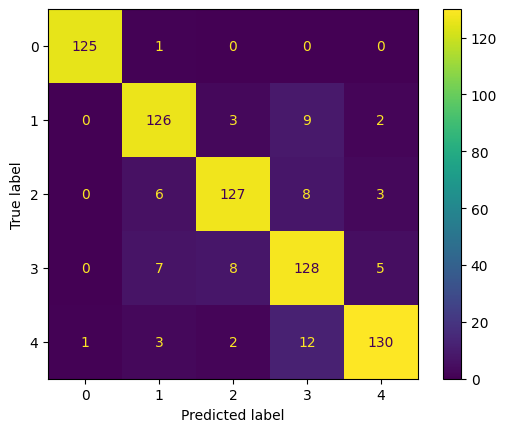

[(0, 'alt.atheism'),
 (1, 'comp.graphics'),
 (2, 'comp.os.ms-windows.misc'),
 (3, 'comp.sys.ibm.pc.hardware'),
 (4, 'comp.sys.mac.hardware')]


In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_tfidf, labels=classifier_tfidf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=range(len(categories)))
disp.plot()
plt.show()
pprint([(x, categories[x]) for x in range(len(categories))])



---



### In depth
(numpy vectors manipulation)



> What are the most important words for a given document?


  
Before begining to answer that question, let us make a few imports and build useful variables.  
  
Numpy will become the main library for that part since it includes a lot of tricky vector manipulation.

In [3]:
import numpy as np

from pprint import pprint
import pandas as pd

We build X_train_preprocessed that corresponds to the documents preprocessed with CountVectorizer's automatic function when fitting/transforming : build_analyzer().

In [4]:
analyzer = vectorizer.build_analyzer()
X_train_preprocessed = []
for elt in X_train:
  X_train_preprocessed.append(' '.join(analyzer(elt)))
X_train_preprocessed[0]

'from joel tekgen bv tek com joseph look subject bar code fonts organization tektronix inc lines am looking for some bar code fonts especially code of did anybody know any ftp sites or bbs that can download these types of fonts please email to me if you have any info thanks'

We also build a useful index to word list of the vocabulary.

In [5]:
w2i = vectorizer.vocabulary_ # word to index dictionnary
i2w = {v: k for k, v in w2i.items()} # reversing dictionnary

Finally, we will randomly select a document from the dataset, and have a look at it.

In [37]:
import random

random_number = random.randrange(0,len(X_train)) # getting a random document
document = X_train[random_number]
splitted_document = document.split('\n')

for line in splitted_document: # extracting document's subject
  if line.split()[0] == 'Subject:':
    subject = line
    break

print('\ndocument n°',random_number, ',', 'category:', categories[y_train[random_number]], '\n')
pprint(splitted_document)


document n° 1118 , category: comp.sys.mac.hardware 

['From: bredell@tdb.uu.se (Mats Bredell)',
 'Subject: Re: Quadra 900 startup w/out monitor...ya right.',
 'Reply-To: Mats.Bredell@udac.uu.se',
 'Organization: Uppsala University Computing Center (UDAC)',
 'X-Newsreader: TIN [version 1.1 PL6]',
 'Lines: 16',
 '',
 'Shawn FitzGerald (chungkuo@umcc.umcc.umich.edu) wrote:',
 ': Is there a fix for this? We have a Quadra 900 that will NOT finish startup',
 ': unless there is a monitor connected. This would be no problem, but since',
 ": we're running it as a file server, there is no need to have a monitor",
 ': connected all the time.',
 '',
 "I've seen a control panel made for this. I don't remember the name, where I",
 'saw it, or on what Quadra models it will work. But I do know it exists :)',
 '',
 '/Mats',
 '',
 '-- ',
 'Mats Bredell                                   Mats.Bredell@udac.uu.se',
 'Uppsala University Computing Center (UDAC)     Ph:  +46 18 187817',
 'Department of medica

These documents are emails. Maybe getting rid of some parts of the emails could improve the classification.

In [38]:
# document_number = random_number

To answer the "most important words" question, we first need to get the tf-idf weights of the document.  
To do so, I followed the following steps :  
1- get the document vector stored in X_train_tfidf  
2- since it is sparse, get the values indices with numpy nonzero() function  
3- give these indices to the sparse vector

In [39]:
document_tfidf = X_train_tfidf[random_number]
non_zero_values_indices = document_tfidf.toarray().nonzero()
non_zero_values = document_tfidf[non_zero_values_indices]
non_zero_values

matrix([[0.03856996, 0.09458546, 0.09604477, 0.09604477, 0.12599018,
         0.14194077, 0.0254257 , 0.0239195 , 0.03982911, 0.48022386,
         0.04090113, 0.10001984, 0.09115558, 0.10600505, 0.12932188,
         0.05069136, 0.04772343, 0.0244327 , 0.02801336, 0.01732915,
         0.05723083, 0.04290754, 0.03836644, 0.08093867, 0.08768664,
         0.05699204, 0.03245289, 0.01205823, 0.08279745, 0.03650799,
         0.04596061, 0.06335435, 0.02639519, 0.01208102, 0.04580216,
         0.38318899, 0.07023936, 0.06511602, 0.1382577 , 0.04667422,
         0.03227763, 0.04276137, 0.05401756, 0.02059993, 0.01416822,
         0.0187197 , 0.02051927, 0.01254028, 0.02801336, 0.06422241,
         0.06827967, 0.06422241, 0.03366368, 0.15654576, 0.03616778,
         0.05171509, 0.0320963 , 0.03787218, 0.04335696, 0.05904948,
         0.15800266, 0.04430942, 0.05723083, 0.08768664, 0.03782385,
         0.12599018, 0.06558895, 0.01205823, 0.06769135, 0.04298129,
         0.09115558, 0.01693035, 0

Then we sort this vector using numpy **argsort()** (more details in the code section).

In [75]:
non_zero_values_array = np.squeeze(np.asarray(non_zero_values)) # matrix shape to array shape
ascending_sorted_weight_indices = non_zero_values_array.argsort()[::-1] # getting sorting indices (descending order)
ascending_sorted_weights = non_zero_values_array[ascending_sorted_weight_indices] # sorting weights vector
ascending_sorted_weights

array([0.48022386, 0.38417909, 0.38318899, 0.20483901, 0.19208954,
       0.16187733, 0.15800266, 0.15654576, 0.14194077, 0.1382577 ,
       0.12932188, 0.12599018, 0.12599018, 0.10600505, 0.10001984,
       0.09604477, 0.09604477, 0.09458546, 0.09115558, 0.09115558,
       0.08768664, 0.08768664, 0.08279745, 0.08093867, 0.07258054,
       0.07023936, 0.06928708, 0.06827967, 0.06769135, 0.06638938,
       0.06558895, 0.06511602, 0.06422241, 0.06422241, 0.06335435,
       0.05904948, 0.05723083, 0.05723083, 0.05699204, 0.05651696,
       0.05608155, 0.05401756, 0.05234163, 0.05212658, 0.05171509,
       0.05069136, 0.04772343, 0.04667422, 0.04596061, 0.04580216,
       0.04430942, 0.04425229, 0.04398351, 0.04335696, 0.04298129,
       0.04290754, 0.04276137, 0.04090113, 0.04069681, 0.03982911,
       0.03856996, 0.03836644, 0.03787218, 0.03782385, 0.03650799,
       0.03620165, 0.03616778, 0.03530804, 0.03499884, 0.03418727,
       0.03411613, 0.03366368, 0.03245289, 0.03227763, 0.03209

Since **the positions in the vectors correspond to word indices in the vocabulary**, the indices returned by the **nonzero()** function correspond to the words present in the document. We can then use the sorted weight indices returned by **argsort()** function and give them to the output of **nonzero()** to get our document words sorted by their tf-idf weights.

In [77]:
sorted_word_indices = non_zero_values_indices[1][ascending_sorted_weight_indices]
sorted_word_indices

array([15445, 49723, 33837, 50561, 50349, 49942, 45099, 42070,  9911,
       35502, 18029, 46782,  5562, 17910, 16708,  1982,  1981,  1934,
       48027, 17100, 45496, 23489, 24628, 23446, 54091, 34245, 48351,
       39870, 47425, 52288, 46941, 35423, 39310, 40161, 28878, 44804,
       45325, 22499, 23496, 48402, 49953, 37385, 50167, 52558, 43172,
       18192, 19751, 36732, 28784, 33472, 45188, 50149, 48563, 44272,
       47563, 23034, 37078, 15744, 53006, 14467,  1708, 23388, 43605,
       45778, 26140, 51152, 42785, 52448, 52867, 48544, 51051, 40887,
       23784, 36932, 43256, 48390, 38816, 20585, 48691, 30868, 48313,
       12637, 52920, 20506, 52437, 13374, 37489, 38605, 38445, 21424,
       48308, 38207, 38652, 31990, 47075, 24054])

In [78]:
sorted_document_words = [i2w[x] for x in sorted_word_indices]

We finally have our result : the words sorted by their tf-idf weights!

We can then know what words were more or less informative in the classification decision by looking to the begining of the list (less informative) or to its end (more informative).  
  
The remaining code will just give us a nice visual with word, tf-idf score, term frequency and document frequency.

In [79]:
term_frequencies = []
for word in sorted_document_words:
  term_frequencies.append(X_train_preprocessed[random_number].count(word))

In [80]:
document_frequencies = {} # initialize
for word in sorted_document_words:
  document_frequencies[word] = 0

In [81]:
for document in X_train_preprocessed: # compute
  for word in sorted_document_words:
    if word in document:
      document_frequencies[word] += 1

In [82]:
document_words_informations = [] # put together
for i in range(len(sorted_document_words)):
  document_words_informations.append(
      (sorted_document_words[i],
      ascending_sorted_weights[i],
      term_frequencies[i],
      document_frequencies[sorted_document_words[i]])
      )

As a list :

In [83]:
print('\nmost important words :'), pprint(document_words_informations[::-1][:5])
print('\nleast important words :'), pprint(document_words_informations[:5])


most important words :
[('from', 0.012058230086592904, 1, 2117),
 ('subject', 0.012058230086592904, 1, 2117),
 ('lines', 0.012081024479177768, 1, 2113),
 ('organization', 0.012540275056889472, 1, 2034),
 ('of', 0.014168216689295618, 1, 1847)]

least important words :
[('bredell', 0.4802238573273034, 5, 1),
 ('udac', 0.38417908586184274, 4, 2),
 ('mats', 0.3831889940362227, 5, 41),
 ('uu', 0.20483901186053868, 3, 177),
 ('uppsala', 0.19208954293092137, 2, 1)]


(None, None)

As a DataFrame :

In [84]:
document_words_informations_pandas = { # for DataFrame
    'word': [x[0] for x in document_words_informations],
    'tf-idf weight': [x[1] for x in document_words_informations],
    'term frequency': [x[2] for x in document_words_informations],
    'document frequency': [x[3] for x in document_words_informations]
    }

In [104]:
pd.DataFrame(document_words_informations_pandas).head(10)

,word,tf-idf weight,term frequency,document frequency
0,bredell,0.480224,5,1
1,udac,0.384179,4,2
2,mats,0.383189,5,41
3,uu,0.204839,3,177
4,uppsala,0.192090,2,1
5,umcc,0.161877,2,6
6,se,0.158003,5,1946
7,quadra,0.156546,3,78
8,900,0.141941,2,70
9,monitor,0.138258,3,146


---
### Gather code in a function

In [98]:
def get_sorted_words(document_number):

  document_tfidf = X_train_tfidf[document_number]
  non_zero_values_indices = document_tfidf.toarray().nonzero()
  non_zero_values = document_tfidf[non_zero_values_indices]

  non_zero_values_array = np.squeeze(np.asarray(non_zero_values)) # matrix shape to array shape
  ascending_sorted_weight_indices = non_zero_values_array.argsort()[::-1] # getting sorting indices (descending order)
  ascending_sorted_weights = non_zero_values_array[ascending_sorted_weight_indices] # sorting weights vector

  sorted_word_indices = non_zero_values_indices[1][ascending_sorted_weight_indices]

  sorted_document_words = [i2w[x] for x in sorted_word_indices]
  return sorted_document_words

In [87]:
def get_words_informations(document_number):

  term_frequencies = []
  for word in sorted_document_words:
    term_frequencies.append(X_train_preprocessed[document_number].count(word))

  document_frequencies = {} # initialize
  for word in sorted_document_words:
    document_frequencies[word] = 0

  for document in X_train_preprocessed: # compute
    for word in sorted_document_words:
      if word in document:
        document_frequencies[word] += 1

  document_words_informations = [] # put together
  for i in range(len(sorted_document_words)):
    document_words_informations.append(
        (sorted_document_words[i],
        ascending_sorted_weights[i],
        term_frequencies[i],
        document_frequencies[sorted_document_words[i]])
        )

  return document_words_informations

In [88]:
def as_dataframe(document_words_informations):

  document_words_informations_pandas = { # for DataFrame
    'word': [x[0] for x in document_words_informations],
    'tf-idf weight': [x[1] for x in document_words_informations],
    'term frequency': [x[2] for x in document_words_informations],
    'document frequency': [x[3] for x in document_words_informations]
    }

  return pd.DataFrame(document_words_informations_pandas)

---
### Playground

In [105]:
random_number = random.randrange(0,len(X_train)) # getting a random document
document = X_train[random_number]
splitted_document = document.split('\n')

In [108]:
splitted_document

['From: tdawson@engin.umich.edu (Chris Herringshaw)',
 'Subject: Newsgroup Split',
 'Organization: University of Michigan Engineering, Ann Arbor',
 'Lines: 11',
 'Distribution: world',
 'NNTP-Posting-Host: po.engin.umich.edu',
 '',
 'Concerning the proposed newsgroup split, I personally am not in favor of',
 'doing this.  I learn an awful lot about all aspects of graphics by reading',
 'this group, from code to hardware to algorithms.  I just think making 5',
 'different groups out of this is a wate, and will only result in a few posts',
 'a week per group.  I kind of like the convenience of having one big forum',
 'for discussing all aspects of graphics.  Anyone else feel this way?',
 'Just curious.',
 '',
 '',
 'Daemon',
 '',
 '']

In [106]:
sorted_document_words = get_sorted_words(random_number)
document_words_informations = get_words_informations(random_number)
document_words_informations_pandas = as_dataframe(document_words_informations)

In [107]:
document_words_informations_pandas.head(10)

,word,tf-idf weight,term frequency,document frequency
0,aspects,0.480224,2,21
1,split,0.384179,2,31
2,engin,0.383189,3,173
3,umich,0.204839,2,54
4,newsgroup,0.192090,2,84
5,of,0.161877,7,1847
6,group,0.158003,5,262
7,graphics,0.156546,2,229
8,this,0.141941,4,1206
9,wate,0.138258,1,53




---

### Learned code



*   **np.array.nonzero()**  

Returns indices of an array's non-zero values. Useful when working with sparse vectors like bag-of-words.




In [91]:
print('final shape:', X_train_bow[0].toarray().flatten().nonzero()[0].shape)
print('initial shape:')
X_train_bow[0]

final shape: (44,)
initial shape:


<1x55351 sparse matrix of type '<class 'numpy.int64'>'
	with 44 stored elements in Compressed Sparse Row format>

We can see that final shape corresponds to number of stored
elements in the initial sparse matrix.

notes : Here, we need to turn the matrix to array and flatten it to 1D array .
nonzero() returns a tuple with empty element in 2nd position hence the final [0] to get the wanted vector.



*   **np.ndarray.argsort()**

Returns the indices that would sort an array. Example below.

In [92]:
a = np.array([6,5,2,4,8,2,6,9,74,1])
print('initial array :', a)
b = a.argsort()
print('indices that would sort the array :', b)
c = [a[x] for x in b] # to get descending order, apply [::-1] to the list
print('sorted array :', c)

initial array : [ 6  5  2  4  8  2  6  9 74  1]
indices that would sort the array : [9 2 5 3 1 0 6 4 7 8]
sorted array : [1, 2, 2, 4, 5, 6, 6, 8, 9, 74]




*   **CountVectorizer.build_analyzer(text)**

The text preprocessing "hidden" function of the CountVectorizer (automatically applied at fitting).  
Tokenizes text by splitting on punctuation and gets rid of tokens < 2 characters.



In [93]:
text_sample = X_train[0][:500]
text_sample

'From: joel@tekgen.bv.tek.com (Joseph Look)\nSubject: Bar code fonts\nOrganization: Tektronix, Inc.\nLines: 3\n\nI am looking for some bar code fonts especially code 3 of 9. Did anybody\nknow  any ftp sites or BBS that I can download these types of fonts? \nPlease email to me if you have any info.  Thanks!\n'

In [94]:
analyzer = vectorizer.build_analyzer()
' '.join(analyzer(text_sample))

'from joel tekgen bv tek com joseph look subject bar code fonts organization tektronix inc lines am looking for some bar code fonts especially code of did anybody know any ftp sites or bbs that can download these types of fonts please email to me if you have any info thanks'



*   **TfidfTransformer.idf_**

Returns the idf computed weights after fitting.

In [95]:
print(tf_idf.idf_.shape) # vocabulary size
tf_idf.idf_

(55351,)


array([4.76640723, 5.32602302, 7.96508035, ..., 7.96508035, 7.96508035,
       7.96508035])



*   **CountVectorizer.get_feature_names_out()**

Returns the vocabulary's words in alphabetic order.

In [96]:
feature_array = np.array(vectorizer.get_feature_names_out())
feature_array

array(['00', '000', '000005102000', ..., 'zzzoh', 'zzzz', 'ªl'],
      dtype=object)